# **MolecularForecast challenge**
*A guide for starting the challenge*

#Imports

In [1]:
# Install necessary libraries
!pip install rdkit xgboost scikit-learn pandas numpy matplotlib transformers torch

In [2]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from itertools import product

from rdkit import Chem
from rdkit.Chem import AllChem
from itertools import islice
from transformers import AutoTokenizer, AutoModel
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

#Load Datasets

##Table 1

In [3]:
table1 = pd.read_excel('Table-1.xlsx')
table1.head()

,Accession Number,Entrez Gene Symbol,Kinase,Mutant,Kinase Group
0,NP_055726.3,AAK1,AAK1,NO,Other
1,NP_005148.2,ABL1,ABL1(E255K)-phosphorylated,YES,TK
2,NP_005148.2,ABL1,ABL1(F317I)-nonphosphorylated,YES,TK
3,NP_005148.2,ABL1,ABL1(F317I)-phosphorylated,YES,TK
4,NP_005148.2,ABL1,ABL1(F317L)-nonphosphorylated,YES,TK


##Table 2

In [4]:
table2 = pd.read_csv('Table-2_train.csv')
table2.head()

,Compound,SMILES,Binding Mode (based on ABL1-phos. vs. -nonphos affinity),S(300nM),S(3000nM)
0,A-674563,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,undetermined,0.1166,0.2772
1,AB-1010,CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...,Type II,0.0337,0.0622
2,ABT-869,CC1=CC(=C(C=C1)F)NC(=O)NC2=CC=C(C=C2)C3=C4C(=C...,undetermined,0.0648,0.1839
3,AC220,CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=CN4C...,Type II,0.0285,0.0751
4,AG-013736,CNC(=O)C1=CC=CC=C1SC2=CC3=C(C=C2)C(=NN3)C=CC4=...,Type I,0.0570,0.1969


##Table 3

In [5]:
table3 = pd.read_excel('Table-3_train.xlsx')
table3.head()

,Accession Number,Entrez Gene Symbol,Kinase,A-674563,AB-1010,ABT-869,AC220,AG-013736,AST-487,AT-7519,...,PP-242,PTK-787,R406,R547,SB-203580,SGX-523,Staurosporine,TAE-684,TG-101348,Vandetanib
0,NP_055726.3,AAK1,AAK1,43.0,10001.0,10001.0,10001.0,1200.0,10001.00,10001.0,...,1600.0,10001.0,410.0,10001.0,10001,10001.0,1.2,470.0,35.0,10001.0
1,NP_005148.2,ABL1,ABL1(E255K)-phosphorylated,10001.0,140.0,10001.0,10001.0,63.0,75.00,10001.0,...,56.0,10001.0,220.0,10001.0,10001,10001.0,22.0,190.0,40.0,13.0
2,NP_005148.2,ABL1,ABL1(F317I)-nonphosphorylated,10001.0,8.0,10001.0,10001.0,2600.0,1.90,10001.0,...,10001.0,10001.0,10001.0,10001.0,10001,10001.0,550.0,93.0,2100.0,770.0
3,NP_005148.2,ABL1,ABL1(F317I)-phosphorylated,10001.0,78.0,10001.0,10001.0,800.0,13.00,10001.0,...,1200.0,10001.0,10001.0,10001.0,10001,10001.0,130.0,14.0,560.0,170.0
4,NP_005148.2,ABL1,ABL1(F317L)-nonphosphorylated,10001.0,10.0,10001.0,10001.0,830.0,0.77,10001.0,...,10001.0,10001.0,10001.0,10001.0,10001,10001.0,170.0,54.0,450.0,75.0


##all_seqs

In [6]:
# Retrieve amino acid sequences from pickle file
with open("all_seqs.pkl", "rb") as f:
    all_seq = pickle.load(f)
list(islice(all_seq, 5))

['AAK1',
 'ABL1(E255K)-phosphorylated',
 'ABL1(F317I)-nonphosphorylated',
 'ABL1(F317I)-phosphorylated',
 'ABL1(F317L)-nonphosphorylated']

##base_seq

In [7]:
with open("base_seq.pkl", "rb") as f:
    base_seq = pickle.load(f)
list(islice(base_seq, 5))

['NP_055726.3', 'NP_005148.2', 'NP_005149.3', 'NP_001096.1', 'NP_004293.1']

##global_embeddings_max_length

In [8]:
embeddings_ml = np.load("global_embeddings_max_length.npy")
embeddings_ml[:5]

array([[-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
         1.0579960e-05,  5.8259507e-06,  9.1596256e-08],
       [-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
         5.5299056e-06,  1.7210321e-05,  2.3178212e-07],
       [-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
         5.2921305e-06,  1.6433652e-05,  2.4846892e-07],
       [-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
         5.2921305e-06,  1.6433652e-05,  2.4846892e-07],
       [-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
         5.4387606e-06,  1.6194173e-05,  2.3473470e-07]], dtype=float32)

##global_embeddings_map

In [9]:
with open("global_embeddings_map.pkl", "rb") as f:
    embedding_map = pickle.load(f)  # {Kinase_Name: Index in global_embeddings}
print(list(embedding_map.items())[:5])  # Show first 5 mappings

[('AAK1', array([-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
        1.0579960e-05,  5.8259507e-06,  9.1596256e-08], dtype=float32)), ('ABL1(E255K)-phosphorylated', array([-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
        5.5299056e-06,  1.7210321e-05,  2.3178212e-07], dtype=float32)), ('ABL1(F317I)-nonphosphorylated', array([-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
        5.2921305e-06,  1.6433652e-05,  2.4846892e-07], dtype=float32)), ('ABL1(F317I)-phosphorylated', array([-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
        5.2921305e-06,  1.6433652e-05,  2.4846892e-07], dtype=float32)), ('ABL1(F317L)-nonphosphorylated', array([-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
        5.4387606e-06,  1.6194173e-05,  2.3473470e-07], dtype=float32))]


In [10]:
import numpy as np

drug_names = np.array([
    'A-674563', 'AB-1010', 'ABT-869', 'AC220', 'AG-013736', 'AST-487', 'AT-7519', 'AZD-1152HQPA',
    'AZD-2171', 'AZD-6244/ARRY-886', 'BI-2536', 'BIBW-2992', 'BIRB-796', 'BMS-345541',
    'BMS-387032/SNS-032', 'BMS-540215', 'CEP-701', 'CHIR-258/TKI-258', 'CHIR-265/RAF-265', 'CI-1033',
    'CP-690550', 'Crizotinib', 'Dasatinib', 'Erlotinib', 'EXEL-2880/GSK-1363089', 'Flavopiridol',
    'GDC-0879', 'GDC-0941', 'Gefitinib', 'GSK-1838705A', 'GSK-690693', 'GW-2580', 'HKI-272',
    'Imatinib', 'INCB18424', 'JNJ-28312141', 'Ki-20227', 'KW-2449', 'Lapatinib', 'LY-317615',
    'LY-333531', 'MLN-120B', 'MLN-518', 'MLN-8054', 'Nilotinib', 'Pazopanib', 'PD-173955',
    'PHA-665752', 'PKC-412', 'PLX-4720', 'PP-242', 'PTK-787', 'R406', 'R547', 'SB-203580',
    'SGX-523', 'Staurosporine', 'TAE-684', 'TG-101348', 'Vandetanib'
])

print(len(drug_names))

# Convert table3 to NumPy array (if not already)
table3 = np.array(table3)

print("Expected number of drugs:", len(drug_names))
# print("Actual number of columns in coeffs:", coeffs.shape[1])

# Extract first 3 columns
three_cols = table3[:, :3]

# Extract the coefficients from column 3 onward
coeffs = table3[:, 3:]

# Create binary classification: 0 if value == 10001, else 1
binary_values = np.where(coeffs == 10001, 0, 1)

# Concatenate first 3 columns with binary data
binary_data = np.hstack((three_cols, binary_values))

column_names = np.concatenate((['Col1', 'Col2', 'Col3'], drug_names))
df_binary = pd.DataFrame(binary_data, columns=column_names)



# Filter rows where at least one value in the row is 0
row_mask = np.any(binary_values == 0, axis=1)
filtered_three_cols = three_cols[row_mask]
filtered_binary_values = binary_values[row_mask]

# Combine first 3 columns with filtered binary data
filtered_data = np.hstack((filtered_three_cols, filtered_binary_values))

# Create column names: first 3 are original, rest come from drug_names
column_names = np.concatenate((['Col1', 'Col2', 'Col3'], drug_names))

# Convert to Pandas DataFrame
df_filtered = pd.DataFrame(filtered_data, columns=column_names)

# Print DataFrame shape and sample
print("Filtered Data Shape:", df_filtered.shape)
print("\nFiltered Data Sample:\n", df_filtered.head())

# Example: Access a specific drug column
print("\nSample of 'A-674563' Column:\n", df_filtered['A-674563'])

60
Expected number of drugs: 60
Filtered Data Shape: (442, 63)

Filtered Data Sample:
           Col1  Col2                           Col3 A-674563 AB-1010 ABT-869  \
0  NP_055726.3  AAK1                           AAK1        1       0       0   
1  NP_005148.2  ABL1     ABL1(E255K)-phosphorylated        0       1       0   
2  NP_005148.2  ABL1  ABL1(F317I)-nonphosphorylated        0       1       0   
3  NP_005148.2  ABL1     ABL1(F317I)-phosphorylated        0       1       0   
4  NP_005148.2  ABL1  ABL1(F317L)-nonphosphorylated        0       1       0   

  AC220 AG-013736 AST-487 AT-7519  ... PP-242 PTK-787 R406 R547 SB-203580  \
0     0         1       0       0  ...      1       0    1    0         0   
1     0         1       1       0  ...      1       0    1    0         0   
2     0         1       1       0  ...      0       0    0    0         0   
3     0         1       1       0  ...      1       0    0    0         0   
4     0         1       1       0  ...      0  

#Assign Embeddings to Each Kinase

In [11]:
# Function to retrieve precomputed embedding for a kinase
def get_precomputed_embedding(kinase_name):
    embedding = embedding_map.get(kinase_name)

    if isinstance(embedding, np.ndarray):  # Ensure it's an array
        return embedding  # Directly return the embedding
    else:
        return np.zeros(embeddings_ml.shape[1])  # Return a zero vector if missing
table3 = pd.read_excel('Table-3_train.xlsx')  # Reload as DataFrame
# print("Reloaded table3 columns:", table3.columns)

# if not isinstance(table3, pd.DataFrame):
#     table3 = pd.DataFrame(table3)

# Apply to Kd dataset
print("Columns in table3:", table3.columns.tolist())

table3["Kinase_Embedding"] = table3["Kinase"].apply(get_precomputed_embedding)
table3.head()

Columns in table3: ['Accession Number', 'Entrez Gene Symbol', 'Kinase', 'A-674563', 'AB-1010', 'ABT-869', 'AC220', 'AG-013736', 'AST-487', 'AT-7519', 'AZD-1152HQPA', 'AZD-2171', 'AZD-6244/ARRY-886', 'BI-2536', 'BIBW-2992', 'BIRB-796', 'BMS-345541', 'BMS-387032/SNS-032', 'BMS-540215', 'CEP-701', 'CHIR-258/TKI-258', 'CHIR-265/RAF-265', 'CI-1033', 'CP-690550', 'Crizotinib', 'Dasatinib', 'Erlotinib', 'EXEL-2880/GSK-1363089', 'Flavopiridol', 'GDC-0879', 'GDC-0941', 'Gefitinib', 'GSK-1838705A', 'GSK-690693', 'GW-2580', 'HKI-272', 'Imatinib', 'INCB18424', 'JNJ-28312141', 'Ki-20227', 'KW-2449', 'Lapatinib', 'LY-317615', 'LY-333531', 'MLN-120B', 'MLN-518', 'MLN-8054', 'Nilotinib', 'Pazopanib', 'PD-173955', 'PHA-665752', 'PKC-412', 'PLX-4720', 'PP-242', 'PTK-787', 'R406', 'R547', 'SB-203580', 'SGX-523', 'Staurosporine', 'TAE-684', 'TG-101348', 'Vandetanib']


,Accession Number,Entrez Gene Symbol,Kinase,A-674563,AB-1010,ABT-869,AC220,AG-013736,AST-487,AT-7519,...,PTK-787,R406,R547,SB-203580,SGX-523,Staurosporine,TAE-684,TG-101348,Vandetanib,Kinase_Embedding
0,NP_055726.3,AAK1,AAK1,43.0,10001.0,10001.0,10001.0,1200.0,10001.00,10001.0,...,10001.0,410.0,10001.0,10001,10001.0,1.2,470.0,35.0,10001.0,"[-0.0042408835, 0.0032960442, -0.015650194, 0...."
1,NP_005148.2,ABL1,ABL1(E255K)-phosphorylated,10001.0,140.0,10001.0,10001.0,63.0,75.00,10001.0,...,10001.0,220.0,10001.0,10001,10001.0,22.0,190.0,40.0,13.0,"[-0.0042408835, 0.0032960442, -0.015650194, 0...."
2,NP_005148.2,ABL1,ABL1(F317I)-nonphosphorylated,10001.0,8.0,10001.0,10001.0,2600.0,1.90,10001.0,...,10001.0,10001.0,10001.0,10001,10001.0,550.0,93.0,2100.0,770.0,"[-0.0042408835, 0.0032960442, -0.015650194, 0...."
3,NP_005148.2,ABL1,ABL1(F317I)-phosphorylated,10001.0,78.0,10001.0,10001.0,800.0,13.00,10001.0,...,10001.0,10001.0,10001.0,10001,10001.0,130.0,14.0,560.0,170.0,"[-0.0042408835, 0.0032960442, -0.015650194, 0...."
4,NP_005148.2,ABL1,ABL1(F317L)-nonphosphorylated,10001.0,10.0,10001.0,10001.0,830.0,0.77,10001.0,...,10001.0,10001.0,10001.0,10001,10001.0,170.0,54.0,450.0,75.0,"[-0.0042408835, 0.0032960442, -0.015650194, 0...."


#Convert SMILES to Fingerprint

In [12]:
def smiles_to_fingerprint(smiles, radius=2, nBits=256):
    mol = Chem.MolFromSmiles(smiles)
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)) if mol else np.zeros(nBits)

table2["Fingerprint"] = table2["SMILES"].apply(smiles_to_fingerprint)

fingerprint = table2["Fingerprint"]

print("Fingerprint as list:", fingerprint)



Fingerprint as list: 0     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1     [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3     [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, ...
4     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5     [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...
6     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...
8     [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...
9     [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...
10    [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
11    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...
12    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, ...
13    [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
14    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
15    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
16    [0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...
17    [0, 0, 0, 0, 0, 0, 0,

[13:24:42] DEPRECATION WARNING: please use MorganGenerator
[13:24:42] DEPRECATION WARNING: please use MorganGenerator
[13:24:42] DEPRECATION WARNING: please use MorganGenerator
[13:24:42] DEPRECATION WARNING: please use MorganGenerator
[13:24:42] DEPRECATION WARNING: please use MorganGenerator
[13:24:42] DEPRECATION WARNING: please use MorganGenerator
[13:24:42] DEPRECATION WARNING: please use MorganGenerator
[13:24:42] DEPRECATION WARNING: please use MorganGenerator
[13:24:42] DEPRECATION WARNING: please use MorganGenerator
[13:24:42] DEPRECATION WARNING: please use MorganGenerator
[13:24:42] DEPRECATION WARNING: please use MorganGenerator
[13:24:42] DEPRECATION WARNING: please use MorganGenerator
[13:24:42] DEPRECATION WARNING: please use MorganGenerator
[13:24:42] DEPRECATION WARNING: please use MorganGenerator
[13:24:42] DEPRECATION WARNING: please use MorganGenerator
[13:24:42] DEPRECATION WARNING: please use MorganGenerator
[13:24:42] DEPRECATION WARNING: please use MorganGenerat

#Encode Kinase Groups

In [13]:
label_encoder = LabelEncoder()
kinase_groups_encoded = label_encoder.fit_transform(table1["Kinase Group"])

#Encode Mutant types

In [14]:
mutant_encoded = label_encoder.fit_transform(table1["Mutant"])

#Encode Binding Mode

In [15]:
binding_mode_encoded = label_encoder.fit_transform(table2["Binding Mode (based on ABL1-phos. vs. -nonphos affinity)"])

#Get Coeffs Of Each Kinase For Each Inhibator

In [16]:
keys = list(table3.keys())[3:-1]
diss_const = table3.get(keys)

#Get Kinase Embedding

In [17]:
kinase_em = table3["Kinase_Embedding"]
kinase_em = np.array([np.asarray(x) for x in kinase_em], dtype=object)

#PCA

In [18]:
scaler = StandardScaler()
kinase_em_standardized = scaler.fit_transform(kinase_em)

n_components = 300 #such that explained variance is 100
pca = PCA(n_components=n_components)
reduced_em = pca.fit_transform(kinase_em_standardized)

In [19]:
X = []

Kd_melted = table3.melt(id_vars=["Kinase"], var_name="Compound", value_name="Kd")

Kd_final = Kd_melted.merge(table2[['Compound', 'Fingerprint']], on="Compound", how="left")

Kd_final = Kd_final.merge(table1[['Kinase', 'Kinase Group', 'Mutant']], on="Kinase", how="left")

#Pre-Processing

In [20]:
print(reduced_em.shape)

(442, 300)


In [21]:
mutant_encoded = np.array(mutant_encoded).reshape(-1, 1)
kinase_groups_encoded = np.array(kinase_groups_encoded).reshape(-1, 1)
reduced_em = np.array(reduced_em)
kinase = np.hstack((mutant_encoded, kinase_groups_encoded, reduced_em))
testing_kinase = kinase

#print(final_array.shape)

fingerprint = np.array(fingerprint).reshape(-1, 1)
binding_mode_encoded = np.array(binding_mode_encoded).reshape(-1, 1)
inihibator = np.hstack((fingerprint, binding_mode_encoded))

kinase = np.repeat(kinase, repeats=60, axis=0)

inihibator = np.tile(inihibator, (442, 1))
print(inihibator.shape)

(26520, 2)


In [22]:
X = np.hstack((kinase, inihibator))

y = np.hstack([diss_const['A-674563'][:], diss_const['AB-1010'][:], diss_const['ABT-869'], diss_const['AC220'], diss_const['AG-013736'], diss_const['AST-487'], diss_const['AT-7519'], diss_const['AZD-1152HQPA'], diss_const['AZD-2171'], diss_const['AZD-6244/ARRY-886'], diss_const['BI-2536'], diss_const['BIBW-2992'], diss_const['BIRB-796'], diss_const['BMS-345541'], diss_const['BMS-387032/SNS-032'], diss_const['BMS-540215'], diss_const['CEP-701'], diss_const['CHIR-258/TKI-258'], diss_const['CHIR-265/RAF-265'], diss_const['CI-1033'], diss_const['CP-690550'], diss_const['Crizotinib'], diss_const['Dasatinib'], diss_const['Erlotinib'], diss_const['EXEL-2880/GSK-1363089'], diss_const['Flavopiridol'], diss_const['GDC-0879'], diss_const['GDC-0941'], diss_const['Gefitinib'], diss_const['GSK-1838705A'], diss_const['GSK-690693'], diss_const['GW-2580'], diss_const['HKI-272'], diss_const['Imatinib'], diss_const['INCB18424'], diss_const['JNJ-28312141'], diss_const['Ki-20227'], diss_const['KW-2449'], diss_const['Lapatinib'], diss_const['LY-317615'], diss_const['LY-333531'], diss_const['MLN-120B'], diss_const['MLN-518'], diss_const['MLN-8054'], diss_const['Nilotinib'], diss_const['Pazopanib'], diss_const['PD-173955'], diss_const['PHA-665752'], diss_const['PKC-412'], diss_const['PLX-4720'], diss_const['PP-242'], diss_const['PTK-787'], diss_const['R406'], diss_const['R547'], diss_const['SB-203580'], diss_const['SGX-523'], diss_const['Staurosporine'], diss_const['TAE-684'], diss_const['TG-101348'], diss_const['Vandetanib']])
y = np.array(y).reshape(-1, 1)

print(X[:5])
print(y[:5])
#[diss_const['A-674563'], diss_const['AB-1010'], diss_const['ABT-869'], diss_const['AC220'], diss_const['AG-013736'], diss_const['AST-487'], diss_const['AT-7519'], diss_const['AZD-1152HQPA'], diss_const['AZD-2171'], diss_const['AZD-6244/ARRY-886'], diss_const['BI-2536'], diss_const['BIBW-2992'], diss_const['BIRB-796'], diss_const['BMS-345541'], diss_const['BMS-387032/SNS-032'], diss_const['BMS-540215'], diss_const['CEP-701'], diss_const['CHIR-258/TKI-258'], diss_const['CHIR-265/RAF-265'], diss_const['CI-1033'], diss_const['CP-690550'], diss_const['Crizotinib'], diss_const['Dasatinib'], diss_const['Erlotinib'], diss_const['EXEL-2880/GSK-1363089'], diss_const['Flavopiridol'], diss_const['GDC-0879'], diss_const['GDC-0941'], diss_const['Gefitinib'], diss_const['GSK-1838705A'], diss_const['GSK-690693'], diss_const['GW-2580'], diss_const['HKI-272'], diss_const['Imatinib'], diss_const['INCB18424'], diss_const['JNJ-28312141'], diss_const['Ki-20227'], diss_const['KW-2449'], diss_const['Lapatinib'], diss_const['LY-317615'], diss_const['LY-333531'], diss_const['MLN-120B'], diss_const['MLN-518'], diss_const['MLN-8054'], diss_const['Nilotinib'], diss_const['Pazopanib'], diss_const['PD-173955'], diss_const['PHA-665752'], diss_const['PKC-412'], diss_const['PLX-4720'], diss_const['PP-242'], diss_const['PTK-787'], diss_const['R406'], diss_const['R547'], diss_const['SB-203580'], diss_const['SGX-523'], diss_const['Staurosporine'], diss_const['TAE-684'], diss_const['TG-101348'], diss_const['Vandetanib']]

[[0.0 6.0 -0.8137522446645905 ... -0.3978031819837683
  array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
         0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
         0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
         0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
  2]
 [0.0 6.0 -0.8137522446645905 ... -0.3978031819837683
  array([0

#Model

Pure Regression

New shape of X: (26520, 559)
Train set shape: (18564, 559)
Y_train set shape: (18564, 1)
[[1.0001e+04]
 [1.0000e+01]
 [6.0000e+00]
 [1.0001e+04]
 [1.0001e+04]]
Validation set shape: (3978, 559)
Test set shape: (3978, 559)
max_depth: 3, Validation MAE: 2404.89
max_depth: 4, Validation MAE: 2252.19
max_depth: 5, Validation MAE: 2270.20
max_depth: 6, Validation MAE: 2231.38
max_depth: 7, Validation MAE: 2374.76
max_depth: 8, Validation MAE: 2201.81
max_depth: 9, Validation MAE: 2265.19
max_depth: 10, Validation MAE: 2455.62

Best max_depth: 8 with Validation MAE: 2201.81


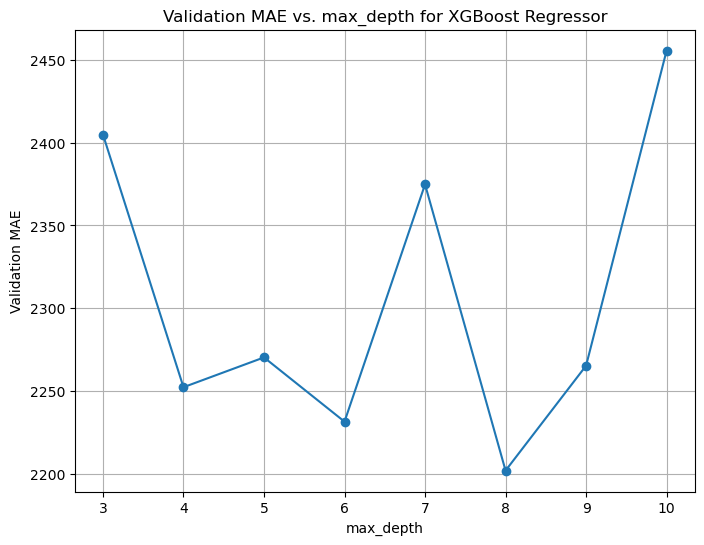


Final Test MAE: 2190.05 nM

Final Test MAE: 1757.48 nM


In [23]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# --- Step 1: Ensure all columns in X are scalars ---
def flatten_features(X):
    """
    Convert an array X of shape (n_samples, n_features) where some features are arrays
    into a uniform 2D array where every feature is a scalar.
    """
    # Convert X to list-of-lists for easier processing.
    X_list = X.tolist()
    n_samples = len(X_list)
    n_features = X.shape[1]
    
    processed_columns = []
    
    for j in range(n_features):
        # Check the first element in this column
        first_elem = X_list[0][j]
        if isinstance(first_elem, (list, np.ndarray)):
            # If it's a nested array, convert every row's j-th element to a flattened array
            col_array = np.array([np.array(row[j]).flatten() for row in X_list])
            # col_array now has shape (n_samples, k) where k is the length of the nested array.
            processed_columns.append(col_array)
        else:
            # If it's a scalar, ensure it's a column vector.
            col_array = np.array([row[j] for row in X_list]).reshape(-1, 1)
            processed_columns.append(col_array)
    
    # Concatenate all columns horizontally
    X_processed = np.hstack(processed_columns)
    return X_processed

Y = np.array(y, dtype=float)

# Flatten any nested columns in X
X_processed = flatten_features(X)
print("New shape of X:", X_processed.shape)

# --- Step 2: Split the data into 70% train, 15% validation, and 15% test ---
X_train_full, X_temp, y_train_full, y_temp = train_test_split(X_processed, Y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print("Train set shape:", X_train_full.shape)
print("Y_train set shape:", y_train_full.shape)
print(y_train_full[:5])
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# --- Step 3: Evaluate different max_depth values using the training and validation sets ---
max_depths = [3,4,5,6,7,8,9,10]
val_mae_values = []

for depth in max_depths:
    model = xgb.XGBRegressor(
        objective='reg:absoluteerror',  # Use MAE as the loss function
        max_depth=depth,
        eval_metric='mae',              # Report MAE during training
        random_state=42
    )
    model.fit(X_train_full, y_train_full)
    y_pred_val = model.predict(X_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    val_mae_values.append(mae_val)
    print(f"max_depth: {depth}, Validation MAE: {mae_val:.2f}")

# Find the best max_depth based on the lowest validation MAE
best_index = np.argmin(val_mae_values)
best_depth = max_depths[best_index]
print(f"\nBest max_depth: {best_depth} with Validation MAE: {val_mae_values[best_index]:.2f}")

# Plot the validation MAE vs. max_depth
plt.figure(figsize=(8, 6))
plt.plot(max_depths, val_mae_values, marker='o', linestyle='-')
plt.xlabel('max_depth')
plt.ylabel('Validation MAE')
plt.title('Validation MAE vs. max_depth for XGBoost Regressor')
plt.grid(True)
plt.show()

# --- Step 4: Retrain final model on training+validation set and evaluate on test set ---
X_train_val = np.concatenate((X_train_full, X_val), axis=0)
y_train_val = np.concatenate((y_train_full, y_val), axis=0)

final_model = xgb.XGBRegressor(
    objective='reg:absoluteerror',
    max_depth=best_depth,
    eval_metric='mae',
    random_state=42
)
final_model.fit(X_train_val, y_train_val)

# Evaluate the final model on the unseen test set
y_pred_test = final_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
print(f"\nFinal Test MAE: {test_mae:.2f} nM")

y_pred_train = final_model.predict(X_train_full)
test_mae = mean_absolute_error(y_train_full, y_pred_train)
print(f"\nFinal Test MAE: {test_mae:.2f} nM")


Binary classification betwen 10001 and others

In [24]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def flatten_features(X):
    """
    Convert an array X of shape (n_samples, n_features) where some features are arrays
    into a uniform 2D array where every feature is a scalar.
    """
    # Convert X to list-of-lists for easier processing.
    X_list = X.tolist()
    n_samples = len(X_list)
    n_features = X.shape[1]
    
    processed_columns = []
    
    for j in range(n_features):
        # Check the first element in this column
        first_elem = X_list[0][j]
        if isinstance(first_elem, (list, np.ndarray)):
            # If it's a nested array, convert every row's j-th element to a flattened array
            col_array = np.array([np.array(row[j]).flatten() for row in X_list])
            # col_array now has shape (n_samples, k) where k is the length of the nested array.
            processed_columns.append(col_array)
        else:
            # If it's a scalar, ensure it's a column vector.
            col_array = np.array([row[j] for row in X_list]).reshape(-1, 1)
            processed_columns.append(col_array)
    
    # Concatenate all columns horizontally
    X_processed = np.hstack(processed_columns)
    return X_processed

Y = np.array(y, dtype=float)

# Flatten any nested columns in X
X_processed = flatten_features(X)
print("New shape of X:", X_processed.shape)
Y_cat = np.where(Y == 10001, 1, 0)
print(Y_cat)

# Split the data: 70% train, 15% validation, 15% test.
X_train, X_temp, y_train, y_temp = train_test_split(X_processed, Y_cat, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

binary_classification_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    max_depth=5,             
    random_state=42
)

binary_classification_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Predict on the test set.
y_pred = binary_classification_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


New shape of X: (26520, 559)
[[0]
 [1]
 [1]
 ...
 [0]
 [0]
 [1]]
Train set shape: (18564, 559)
Validation set shape: (3978, 559)
Test set shape: (3978, 559)
[0]	validation_0-mlogloss:0.61763
[1]	validation_0-mlogloss:0.56986
[2]	validation_0-mlogloss:0.53889
[3]	validation_0-mlogloss:0.52303
[4]	validation_0-mlogloss:0.51137
[5]	validation_0-mlogloss:0.50309
[6]	validation_0-mlogloss:0.49917
[7]	validation_0-mlogloss:0.49246
[8]	validation_0-mlogloss:0.49043
[9]	validation_0-mlogloss:0.48710
[10]	validation_0-mlogloss:0.48505
[11]	validation_0-mlogloss:0.48341
[12]	validation_0-mlogloss:0.48221
[13]	validation_0-mlogloss:0.48152
[14]	validation_0-mlogloss:0.48124
[15]	validation_0-mlogloss:0.48055
[16]	validation_0-mlogloss:0.48031
[17]	validation_0-mlogloss:0.47965
[18]	validation_0-mlogloss:0.47933
[19]	validation_0-mlogloss:0.47921
[20]	validation_0-mlogloss:0.47872
[21]	validation_0-mlogloss:0.47859
[22]	validation_0-mlogloss:0.48052
[23]	validation_0-mlogloss:0.48032
[24]	validati

regression on correlated data

Shape of Y after squeeze: (26520,)
Mask shape: (26520,)
Filtered X shape: (7680, 559)
Filtered Y shape: (7680, 1)
Train set shape: (5376, 559)
Validation set shape: (1152, 559)
Test set shape: (1152, 559)
max_depth: 1, Validation MAE: 1388.88
max_depth: 2, Validation MAE: 1357.86
max_depth: 3, Validation MAE: 1369.94
max_depth: 4, Validation MAE: 1371.87
max_depth: 5, Validation MAE: 1405.42
max_depth: 6, Validation MAE: 1414.14
max_depth: 7, Validation MAE: 1431.39
max_depth: 8, Validation MAE: 1483.70
max_depth: 9, Validation MAE: 1496.16
max_depth: 10, Validation MAE: 1499.20

Best max_depth: 2 with Validation MAE: 1357.86


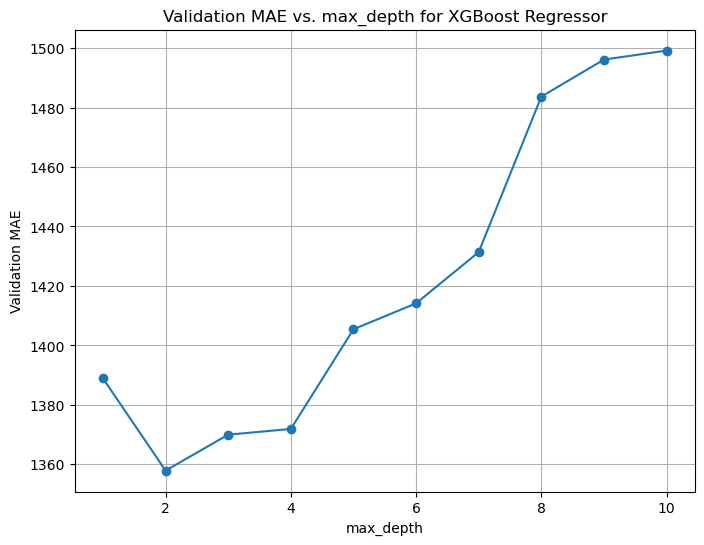


Final Test MAE: 1174.15 nM
[ 755.59436   129.50392   346.19       49.003117 1469.0698  ]
[[3.5e+03]
 [2.7e+03]
 [4.7e+02]
 [2.4e+00]
 [4.7e+03]]


In [25]:
import numpy as np

# Ensure Y is a 1D array (flattening if necessary)
Y = np.squeeze(Y)   # Now Y should have shape (n,) instead of (1, n)

# Verify the shape of Y
print("Shape of Y after squeeze:", Y.shape)

# Create a boolean mask where Y is not equal to 10001
mask = (Y != 10001)
print("Mask shape:", mask.shape)

# Now use the mask to filter rows in X and Y.
X_filtered = X_processed[mask]

Y_filtered = Y[mask]
Y_filtered = Y_filtered.reshape(-1, 1)


print("Filtered X shape:", X_filtered.shape)
print("Filtered Y shape:", Y_filtered.shape)

X_train_full, X_temp, y_train_full, y_temp = train_test_split(X_filtered, Y_filtered, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print("Train set shape:", X_train_full.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# --- Step 3: Evaluate different max_depth values using the training and validation sets ---
max_depths = [1,2,3,4,5,6,7,8,9,10]
val_mae_values = []

for depth in max_depths:
    model = xgb.XGBRegressor(
        objective='reg:absoluteerror',  # Use MAE as the loss function
        max_depth=depth,
        eval_metric='mae',              # Report MAE during training
        random_state=42
    )
    model.fit(X_train_full, y_train_full)
    y_pred_val = model.predict(X_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    val_mae_values.append(mae_val)
    print(f"max_depth: {depth}, Validation MAE: {mae_val:.2f}")

# Find the best max_depth based on the lowest validation MAE
best_index = np.argmin(val_mae_values)
best_depth = max_depths[best_index]
print(f"\nBest max_depth: {best_depth} with Validation MAE: {val_mae_values[best_index]:.2f}")

# Plot the validation MAE vs. max_depth
plt.figure(figsize=(8, 6))
plt.plot(max_depths, val_mae_values, marker='o', linestyle='-')
plt.xlabel('max_depth')
plt.ylabel('Validation MAE')
plt.title('Validation MAE vs. max_depth for XGBoost Regressor')
plt.grid(True)
plt.show()

# --- Step 4: Retrain final model on training+validation set and evaluate on test set ---
X_train_val = np.concatenate((X_train_full, X_val), axis=0)
y_train_val = np.concatenate((y_train_full, y_val), axis=0)

regression_model = xgb.XGBRegressor(
    objective='reg:absoluteerror',
    max_depth=best_depth,
    eval_metric='mae',
    random_state=42
)
regression_model.fit(X_train_val, y_train_val)

# Evaluate the final model on the unseen test set
y_pred_test = regression_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
print(f"\nFinal Test MAE: {test_mae:.2f} nM")

print(y_pred_test[:5])
print(y_test[:5])




Final Training

In [26]:
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report

# --- Flattening Function ---
def flatten_features(X):
    """
    Convert an array X of shape (n_samples, n_features) where some features are sequences
    (lists or arrays) into a uniform 2D array where every feature is a scalar.
    """
    X_list = X.tolist()
    n_samples = len(X_list)
    n_features = X.shape[1]
    processed_columns = []
    
    for j in range(n_features):
        col = [row[j] for row in X_list]
        # If the first element is a sequence, assume the whole column is and flatten it
        if isinstance(col[0], (list, np.ndarray)):
            col = np.array([np.array(x).flatten() for x in col])
        else:
            col = np.array(col).reshape(-1, 1)
        processed_columns.append(col)
    
    X_processed = np.hstack(processed_columns)
    return X_processed

Y_test_raw = np.array(y_test, dtype=float).ravel()


X_test = flatten_features(X_test)
print("X_test shape:", X_test.shape)

Y_cat_test = np.where(Y_test_raw == 10001, 1, 0)

y_pred_classifier = binary_classification_model.predict(X_test)

y_pred_regression = regression_model.predict(X_test)
y_pred_combined = np.where(y_pred_classifier == 1, 10001, y_pred_regression)

clf_accuracy = accuracy_score(Y_cat_test, y_pred_classifier)
print("Binary Classification Accuracy: {:.2f}%".format(clf_accuracy * 100))
print("Classification Report:")
print(classification_report(Y_cat_test, y_pred_classifier))

combined_mae = mean_absolute_error(Y_test_raw, y_pred_combined)
print("Combined Model MAE: {:.2f} nM".format(combined_mae))

# --- (Optional) Display a Comparison of Predictions ---
comparison_df = pd.DataFrame({
    'Predicted Kd': y_pred_combined,
    'Actual Kd': Y_test_raw,
    'Predicted Class': y_pred_classifier,
    'True Class': Y_cat_test
})
print(comparison_df.head(10))


X_test shape: (1152, 559)
Binary Classification Accuracy: 61.20%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.61      0.76      1152
           1       0.00      0.00      0.00         0

    accuracy                           0.61      1152
   macro avg       0.50      0.31      0.38      1152
weighted avg       1.00      0.61      0.76      1152

Combined Model MAE: 3834.99 nM
   Predicted Kd  Actual Kd  Predicted Class  True Class
0  10001.000000     3500.0                1           0
1    129.503922     2700.0                0           0
2  10001.000000      470.0                1           0
3     49.003117        2.4                0           0
4  10001.000000     4700.0                1           0
5  10001.000000      390.0                1           0
6    374.398743      320.0                0           0
7    193.117020      260.0                0           0
8    181.060181       37.0                0       

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Testing on new inhibitor data

In [27]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA

# ---- Step 1: Load Test Datasets ----
table1 = pd.read_excel('Table-1.xlsx')  # Kinase & Mutant encoding
table2_test = pd.read_csv('Table-2_test.csv')  # Drug info (SMILES, Binding Mode)
table3_test = pd.read_excel('Table-3_test.xlsx')  # Kinase-Inhibitor Kd values

# ---- Step 2: Convert SMILES to Molecular Fingerprint ----
def smiles_to_fingerprint(smiles, radius=2, nBits=256):
    mol = Chem.MolFromSmiles(smiles)
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)) if mol else np.zeros(nBits)

table2_test["Fingerprint"] = table2_test["SMILES"].apply(smiles_to_fingerprint)

# ---- Step 3: Encode Categorical Features (Kinase & Mutant Types) ----
label_encoder_kinase = LabelEncoder()
label_encoder_mutant = LabelEncoder()

table1["Kinase Group Encoded"] = label_encoder_kinase.fit_transform(table1["Kinase Group"])
table1["Mutant Encoded"] = label_encoder_mutant.fit_transform(table1["Mutant"])

# ---- Step 4: Retrieve Precomputed Kinase Embeddings ----
with open("global_embeddings_map.pkl", "rb") as f:
    embedding_map = pickle.load(f)

def get_precomputed_embedding(kinase_name):
    return embedding_map.get(kinase_name, np.zeros(128))  # Assuming 128-D embeddings

table3_test["Kinase_Embedding"] = table3_test["Kinase"].apply(get_precomputed_embedding)

# ---- Step 5: Extract Drug Names & Dissociation Constants ----
# Extract the 12 inhibitors from Table-2_test.csv
drug_names = table2_test["Compound"].values  # Use the 12 inhibitors from Table-2_test.csv

# Ensure all drug names exist in table3_test
valid_drug_columns = [drug for drug in drug_names if drug in table3_test.columns]

if not valid_drug_columns:
    raise ValueError("None of the drug names in Table-2_test.csv exist in Table-3_test.xlsx!")

# Extract first 3 columns (metadata) from Table-3_test.xlsx
three_cols_test = table3_test.iloc[:, :3].values  # Convert to NumPy array

# Extract Kd values (Dissociation Constants) for the valid inhibitors
coeffs_test = table3_test[valid_drug_columns].values  # Extract Kd values

# ---- Step 7: Expand Features for Kinase & Drug ----
# Repeat each kinase based on the number of valid inhibitors
kinase_repeated_test = np.repeat(three_cols_test, repeats=len(valid_drug_columns), axis=0)

# Tile the valid drug names to match the repeated kinases
inhibitor_tiled_test = np.tile(valid_drug_columns, len(table3_test))

# Encode kinase and mutant types
encoder_kinase = LabelEncoder()
encoder_mutant = LabelEncoder()

kinase_numeric_test = encoder_kinase.fit_transform(kinase_repeated_test[:, 1])
mutant_numeric_test = encoder_mutant.fit_transform(kinase_repeated_test[:, 2])

# ---- Step 8: Apply PCA to Kinase Embeddings ----
# Extract kinase embeddings and convert to NumPy array
kinase_embeddings = np.stack(table3_test["Kinase_Embedding"].values)

# Standardize embeddings
scaler = StandardScaler()
kinase_embeddings_standardized = scaler.fit_transform(kinase_embeddings)

# Apply PCA (Ensure number of components is valid)
n_components = 300  # Reduce to 50 components
pca = PCA(n_components=n_components)
reduced_embeddings_test = pca.fit_transform(kinase_embeddings_standardized)

# Create a dictionary for mapping kinase names to PCA embeddings
kinase_pca_dict_test = {kinase: pca_vector for kinase, pca_vector in zip(table3_test["Kinase"], reduced_embeddings_test)}

# Ensure that all kinases in test set exist in PCA mapping
# pca_values_test = np.array([kinase_pca_dict_test.get(k, np.zeros(50)) for k in kinase_repeated_test[:, 1]])

# ---- Step 9: Merge with Fingerprint Data ----
fingerprint_test = np.array([table2_test.loc[table2_test['Compound'] == inhibitor, "Fingerprint"].values[0]
                             for inhibitor in inhibitor_tiled_test])
binding_mode_test = np.array([
    table2_test.loc[table2_test['Compound'] == inhibitor, "Binding Mode (based on ABL1-phos. vs. -nonphos affinity)"].values[0]
    for inhibitor in inhibitor_tiled_test
])

label_encoder = LabelEncoder()
binding_mode_encoded_testing = label_encoder.fit_transform(binding_mode_test)
binding_mode_encoded_testing = binding_mode_encoded_testing.reshape(-1, 1)
print(binding_mode_encoded_testing.shape)

fingerprint_with_binding = np.hstack((fingerprint_test, binding_mode_encoded_testing))
# ---- Step 10: Stack Feature Matrices ----
# Combine kinase features (mutant encoded + PCA embeddings)
# kinase_test = np.hstack((mutant_numeric_test.reshape(-1, 1), pca_values_test))
print(testing_kinase.shape)


# Combine inhibitor features (fingerprint)
inhibitor_test = fingerprint_test
testing_kinase_final = np.repeat(testing_kinase, repeats=12, axis=0)
print(inhibitor_test.shape)

# Repeat kinase features and tile inhibitor features to match the flattened format

inhibitor_test = np.hstack((inhibitor_test, binding_mode_encoded_testing))


X_test = np.hstack((testing_kinase_final, inhibitor_test))

# Flatten the binary labels
y_test = coeffs_test.flatten()

# ---- Step 11: Verify Data Shape ----
print("X_test Shape:", X_test.shape)  # Should be (num_kinases * num_inhibitors, n_features)
print("y_test Shape:", y_test.shape)  # Should be (


[13:25:10] DEPRECATION WARNING: please use MorganGenerator
[13:25:10] DEPRECATION WARNING: please use MorganGenerator
[13:25:10] DEPRECATION WARNING: please use MorganGenerator
[13:25:10] DEPRECATION WARNING: please use MorganGenerator
[13:25:10] DEPRECATION WARNING: please use MorganGenerator
[13:25:10] DEPRECATION WARNING: please use MorganGenerator
[13:25:10] DEPRECATION WARNING: please use MorganGenerator
[13:25:10] DEPRECATION WARNING: please use MorganGenerator
[13:25:10] DEPRECATION WARNING: please use MorganGenerator
[13:25:10] DEPRECATION WARNING: please use MorganGenerator
[13:25:10] DEPRECATION WARNING: please use MorganGenerator
[13:25:10] DEPRECATION WARNING: please use MorganGenerator


(5304, 1)
(442, 302)
(5304, 256)
X_test Shape: (5304, 559)
y_test Shape: (5304,)


In [28]:
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report

# --- Flattening Function ---
def flatten_features(X):
    """
    Convert an array X of shape (n_samples, n_features) where some features are sequences
    (lists or arrays) into a uniform 2D array where every feature is a scalar.
    """
    X_list = X.tolist()
    n_samples = len(X_list)
    n_features = X.shape[1]
    processed_columns = []
    
    for j in range(n_features):
        col = [row[j] for row in X_list]
        # If the first element is a sequence, assume the whole column is and flatten it
        if isinstance(col[0], (list, np.ndarray)):
            col = np.array([np.array(x).flatten() for x in col])
        else:
            col = np.array(col).reshape(-1, 1)
        processed_columns.append(col)
    
    X_processed = np.hstack(processed_columns)
    return X_processed


Y_test_raw = np.array(y_test, dtype=float).ravel()
X_test = flatten_features(X_test)
print("X_test shape:", X_test.shape)


Y_cat_test = np.where(Y_test_raw == 10001, 1, 0)
y_pred_classifier = binary_classification_model.predict(X_test)
y_pred_regression = regression_model.predict(X_test)
y_pred_combined = np.where(y_pred_classifier == 1, 10001, y_pred_regression)

clf_accuracy = accuracy_score(Y_cat_test, y_pred_classifier)
print("Binary Classification Accuracy: {:.2f}%".format(clf_accuracy * 100))
print("Classification Report:")
print(classification_report(Y_cat_test, y_pred_classifier))

combined_mae = mean_absolute_error(Y_test_raw, y_pred_combined)
print("Combined Model MAE: {:.2f} nM".format(combined_mae))


comparison_df = pd.DataFrame({
    'Predicted Kd': y_pred_combined,
    'Actual Kd': Y_test_raw,
    'Predicted Class': y_pred_classifier,
    'True Class': Y_cat_test
})

X_test shape: (5304, 559)
Binary Classification Accuracy: 59.86%
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.21      0.25      1744
           1       0.67      0.79      0.73      3560

    accuracy                           0.60      5304
   macro avg       0.50      0.50      0.49      5304
weighted avg       0.56      0.60      0.57      5304

Combined Model MAE: 3597.68 nM


Pure Regression

In [29]:
y_pred_test = final_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
print(f"\nFinal Test MAE: {test_mae:.2f} nM")


Final Test MAE: 3257.05 nM
